In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_w = 28
img_h = 28
channels = 1

img_shape = (img_w, img_h, channels)

z_dim = 100

In [3]:
iterations = 20000
batch_size = 128
print_interval = 4000

In [4]:
(X_train, _), (_, _) = mnist.load_data()

In [5]:
def build_gen(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(128, input_dim=z_dim))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(img_shape[0] * img_shape[1] * img_shape[2], activation='tanh'))
  model.add(Reshape(img_shape))
  model._name = "generator"
  return model

In [6]:
generator = build_gen(img_shape, z_dim)

In [7]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


In [8]:
def build_dis(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(1, activation='sigmoid'))
  model._name = "discriminator"
  return model

In [9]:
discriminator = build_dis(img_shape)

In [10]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [11]:
def build_gan(gen, dis):
  model = Sequential()
  model.add(gen)
  model.add(dis)
  model._name = 'gan'
  return model

In [12]:
discriminator.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [13]:
gan.summary()

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 28, 28, 1)         114064    
                                                                 
 discriminator (Sequential)  (None, 1)                 100609    
                                                                 
Total params: 214,673
Trainable params: 114,064
Non-trainable params: 100,609
_________________________________________________________________


# **Training the GAN**

In [14]:
losses = []
accuracies = []
checkpoints = []

def train_gan(X_train, iterations, batch_size, print_every_interval):
  
  X_train = X_train / 127.5 - 1
  X_train = np.expand_dims(X_train, axis=3)
  real = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))
  for i in range(iterations):
    idx = np.random.randint(0, X_train.shape[0], size=batch_size)
    imgs = X_train[idx]
    # lets hear some noise for the discriminator:
    z = np.random.normal(size=(batch_size, z_dim))
    gen_imgs = generator.predict(z)
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = np.add(d_loss_real, d_loss_fake) / 2.0

    # lets hear some noise for the generator:
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)
    g_loss = gan.train_on_batch(z, real)

    if i % print_every_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(accuracy)
      checkpoints.append(i + 1)
      print(f"""
        Iteratrion {i+1}: 
        Discriminator loss: {d_loss}. 
        Generator loss: {g_loss}. 
        """)
      sample_images(generator)
    

In [15]:
def sample_images(generator, img_grid_rows=4, img_grid_cols=4):
  z = np.random.normal(0, 1, (img_grid_rows * img_grid_cols, z_dim))
  gen_imgs = generator.predict(z)
  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5
  fig, axs = plt.subplots(img_grid_rows,
                         img_grid_rows,
                         figsize=(4, 4),
                         sharex=True,
                         sharey=True)
  count = 0
  for i in range(img_grid_rows):
    for j in range(img_grid_cols):
      axs[i,j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      count += 1


        Iteratrion 1: 
        Discriminator loss: 0.871799886226654. 
        Generator loss: 0.628547191619873. 
        

        Iteratrion 4001: 
        Discriminator loss: 0.3113386332988739. 
        Generator loss: 3.7884812355041504. 
        

        Iteratrion 8001: 
        Discriminator loss: 0.5186539590358734. 
        Generator loss: 2.19523286819458. 
        

        Iteratrion 12001: 
        Discriminator loss: 0.6238560080528259. 
        Generator loss: 1.7116262912750244. 
        

        Iteratrion 16001: 
        Discriminator loss: 0.6398606896400452. 
        Generator loss: 1.2972545623779297. 
        


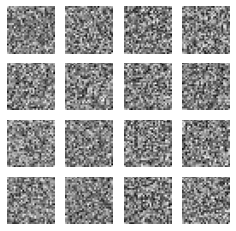

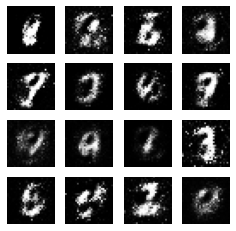

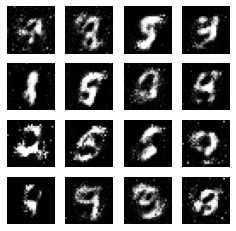

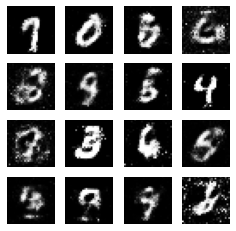

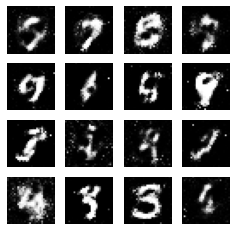

In [16]:
 # Train the GAN for the specified number of iterations
train_gan(X_train, iterations, batch_size, print_interval)

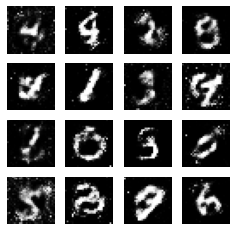

In [17]:
# show the final status of the generator:
sample_images(generator)